In [60]:
import numpy
# scipy.special für die Sigmoid-Funktion expit()
import scipy.special
# Bibliothek zum Plotten von Arrays
import matplotlib.pyplot as plt
# sicherstellen, dass die Plots in diesem Notebook und nicht in einem externen Fenster angezeigt werden
%matplotlib inline

In [61]:
# Definition der neuronalen Netzwerkklasse
class neuralNetwork:

    # Initialisierung des neuronalen Netzwerks
    def __init__(self, inputnodes, hiddennodes, outputnodes, learningrate):
        # Anzahl der Nodes in jeder Input-, hidden und output layer festlegen
        self.inodes = inputnodes
        self.hnodes = hiddennodes
        self.onodes = outputnodes

        # Gewichtsmatrizen, wih und who
        self.wih = numpy.random.normal(0.0, pow(self.inodes, -0.5), (self.hnodes, self.inodes))
        self.who = numpy.random.normal(0.0, pow(self.hnodes, -0.5), (self.onodes, self.hnodes))

        # Lernrate
        self.lr = learningrate

        # Aktivierungsfunktion ist die Sigmoid-Funktion
        self.activation_function = lambda x: scipy.special.expit(x)

        pass

    # Trainieren des neuronalen Netzwerks
    def train(self, inputs_list, targets_list):
        # Inputs in ein 2D-Array umwandeln
        inputs = numpy.array(inputs_list, ndmin=2).T
        targets = numpy.array(targets_list, ndmin=2).T

        # Signale in dem Hidden Layer berechnen
        hidden_inputs = numpy.dot(self.wih, inputs)
        # Signale berechnen, die aus dem Hidden Layer hervorgehen
        hidden_outputs = self.activation_function(hidden_inputs)

        # Signale in dem endgültigen Output Layer berechnen
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # Signale berechnen, die aus dem endgültigen Output Layer  hervorgehen
        final_outputs = self.activation_function(final_inputs)

        # Fehler in dem Output Layer ist (Ziel - Ist)
        output_errors = targets - final_outputs
        # Fehler in dem Hidden Layer ist der output_errors, aufgeteilt nach Gewichten, neu kombiniert an den Hidden Nodes
        hidden_errors = numpy.dot(self.who.T, output_errors)

        # Gewichte für die Verbindungen zwischen den hidden und den Output Layers aktualisieren
        self.who += self.lr * numpy.dot((output_errors * final_outputs * (1.0 - final_outputs)), numpy.transpose(hidden_outputs))

        # Gewichte für die Verbindungen zwischen den Input- und den Hidden Layern aktualisieren
        self.wih += self.lr * numpy.dot((hidden_errors * hidden_outputs * (1.0 - hidden_outputs)), numpy.transpose(inputs))

        pass

    # Abfragen des neuronalen Netzwerks
    def query(self, inputs_list):
        # Input List in ein 2D-Array umwandeln
        inputs = numpy.array(inputs_list, ndmin=2).T

        # Signale in die Hidden Layern berechnen
        hidden_inputs = numpy.dot(self.wih, inputs)
        # Signale berechnen, die aus dem Hidden Layer hervorgehen
        hidden_outputs = self.activation_function(hidden_inputs)

        # Signale in den endgültigen Output Layer berechnen
        final_inputs = numpy.dot(self.who, hidden_outputs)
        # Signale berechnen, die aus dem endgültigen Output Layer hervorgehen
        final_outputs = self.activation_function(final_inputs)

        return final_outputs

In [62]:
# Anzahl an input, hidden und output nodes
input_nodes = 784
hidden_nodes = 15
output_nodes = 1

# Lernrate
learning_rate = 0.05

# Erstelle Instanz des neuronalen Netzwerks
n = neuralNetwork(input_nodes,hidden_nodes,output_nodes, learning_rate)

In [63]:
with open("../data/fashion-mnist_train.csv", 'r') as training_data_file:
    training_data_list = training_data_file.readlines()[1:]

In [64]:
with open("../data/fashion-mnist_test.csv", 'r') as test_data_file:
    test_data_list = test_data_file.readlines()[1:]

In [75]:
# Epochen ist die Anzahl der Male, die der Trainingsdatensatz zum Training verwendet wird
epochs = 1

# Erstellen Sie eine Liste von 10 Ensembles, die jeweils 10 Modelle enthalten
ensembles = []
for _ in range(5):
    ensemble = []
    for i in range(10):
        ensemble.append(neuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate))
    ensembles.append(ensemble)

In [ ]:
train_confidences = []
for ensemble in ensembles:
    for i in range(10):
        for e in range(epochs):
            for record in training_data_list:
                all_values = record.split(',')
                inputs = (numpy.asarray(all_values[1:], dtype=float) / 255.0 * 0.99) + 0.01
                target = numpy.array([0.99 if int(all_values[0]) == i else 0.01])
                ensemble[i].train(inputs, target)
                train_confidences.append(ensemble[i].query(inputs)[0])

In [72]:
import numpy as np

# Test each image with all models in all ensembles
test_confidences = []
scorecard = []
for record in test_data_list:
    all_values = record.split(',')
    correct_label = int(all_values[0])
    inputs = (np.asarray(all_values[1:], dtype=float) / 255.0 * 0.99) + 0.01
    ensemble_outputs = []
    for ensemble in ensembles:
        outputs = [model.query(inputs) for model in ensemble]
        predicted_labels = [i for i, output in enumerate(outputs) if output[0] > 0.5]
        ensemble_outputs.extend(predicted_labels)

    if ensemble_outputs:
        final_prediction = max(set(ensemble_outputs), key=ensemble_outputs.count)
    else:
        final_prediction = -1  # Default prediction for no predictions case

    if correct_label == final_prediction:
        scorecard.append(1)
    else:
        scorecard.append(0)

# Calculate performance
performance = sum(scorecard) / len(scorecard)
print(f'Performance: {performance}')

Performance: 0.7721


In [73]:
# Test each image with all models in all ensembles
test_confidences = []
scorecard = []
for record in test_data_list:
    all_values = record.split(',')
    correct_label = int(all_values[0])
    inputs = (numpy.asarray(all_values[1:], dtype=float) / 255.0 * 0.99) + 0.01
    ensemble_outputs = []
    for ensemble in ensembles:
        outputs = [model.query(inputs) for model in ensemble]
        predicted_labels = [i for i, output in enumerate(outputs) if output[0] > 0.5]
        ensemble_outputs.append(predicted_labels)
        test_confidences.extend([output[0] for output in outputs])
    all_predictions = sum(ensemble_outputs, [])
    if all_predictions:
        final_prediction = max(set(all_predictions), key=all_predictions.count)
        confidence = all_predictions.count(final_prediction) / len(all_predictions)
        if confidence < 0.5:
            final_prediction = -1  # Mark as false classification
        if correct_label == final_prediction:
            scorecard.append(1)
        else:
            scorecard.append(0)
    else:
        scorecard.append(0)

# Calculate performance
performance = sum(scorecard) / len(scorecard)
print(f'Performance: {performance}')

Performance: 0.7721


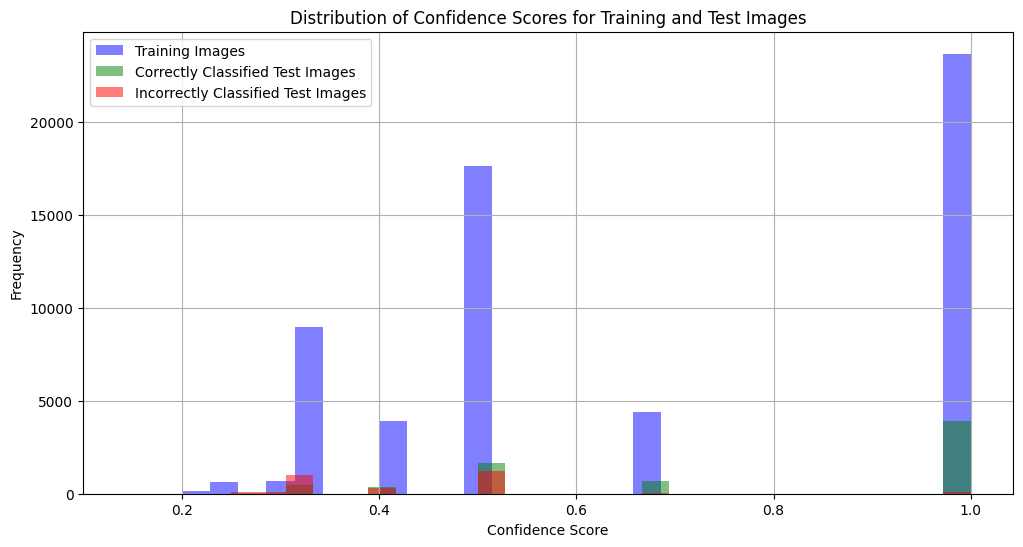

In [71]:
import numpy as np
import matplotlib.pyplot as plt

# Arrays for the confidence values
train_confidences = []
test_confidences_correct = []
test_confidences_incorrect = []

# Analyze the training data
for record in training_data_list:
    all_values = record.split(',')
    if len(all_values) != 785:
        continue

    correct_label = int(all_values[0])
    inputs = (np.asarray(all_values[1:], dtype=float) / 255.0 * 0.99) + 0.01
    ensemble_predictions = []

    for ensemble in ensembles:
        outputs = [model.query(inputs) for model in ensemble]
        predicted_labels = [i for i, output in enumerate(outputs) if output[0] > 0.1]
        ensemble_predictions.extend(predicted_labels)

    if ensemble_predictions:
        most_common = max(set(ensemble_predictions), key=ensemble_predictions.count)
        confidence = ensemble_predictions.count(most_common) / len(ensemble_predictions)
        train_confidences.append(confidence)

# Analyze the test data
for record in test_data_list:
    all_values = record.split(',')
    if len(all_values) != 785:
        continue

    correct_label = int(all_values[0])
    inputs = (np.asarray(all_values[1:], dtype=float) / 255.0 * 0.99) + 0.01
    ensemble_predictions = []

    for ensemble in ensembles:
        outputs = [model.query(inputs) for model in ensemble]
        predicted_labels = [i for i, output in enumerate(outputs) if output[0] > 0.1]
        ensemble_predictions.extend(predicted_labels)

    if ensemble_predictions:
        most_common = max(set(ensemble_predictions), key=ensemble_predictions.count)
        confidence = ensemble_predictions.count(most_common) / len(ensemble_predictions)

        if most_common == correct_label:
            test_confidences_correct.append(confidence)
        else:
            test_confidences_incorrect.append(confidence)

# Visualization
plt.figure(figsize=(12, 6))
plt.hist(train_confidences, bins=30, alpha=0.5, label='Training Images', color='blue')
plt.hist(test_confidences_correct, bins=30, alpha=0.5, label='Correctly Classified Test Images', color='green')
plt.hist(test_confidences_incorrect, bins=30, alpha=0.5, label='Incorrectly Classified Test Images', color='red')
plt.xlabel('Confidence Score')
plt.ylabel('Frequency')
plt.title('Distribution of Confidence Scores for Training and Test Images')
plt.legend()
plt.grid(True)
plt.show()

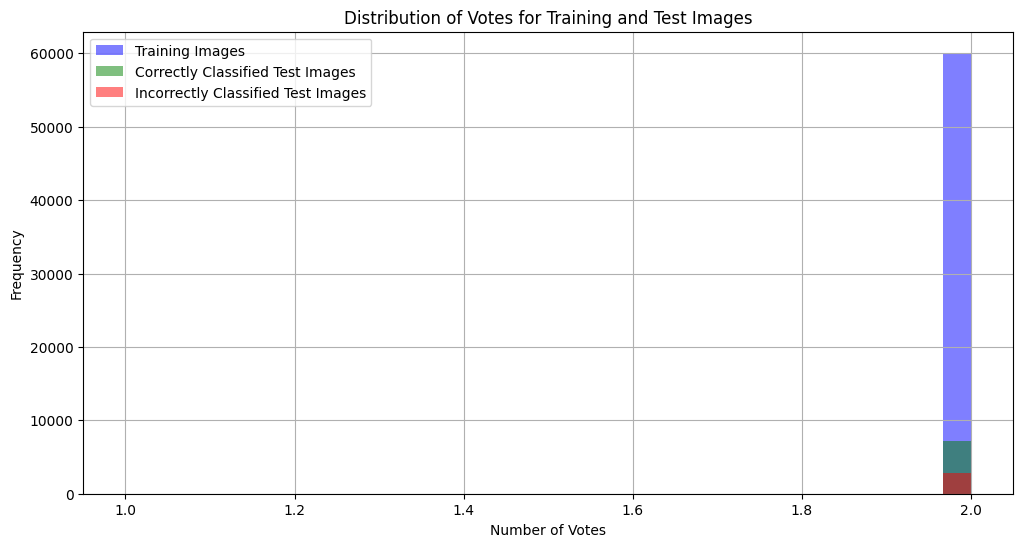

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# Arrays for the vote counts
train_votes = []
test_votes_correct = []
test_votes_incorrect = []

# Analyze the training data
for record in training_data_list:
    all_values = record.split(',')
    if len(all_values) != 785:
        continue

    correct_label = int(all_values[0])
    inputs = (np.asarray(all_values[1:], dtype=float) / 255.0 * 0.99) + 0.01
    ensemble_predictions = []

    for ensemble in ensembles:
        outputs = [model.query(inputs) for model in ensemble]
        predicted_labels = [i for i, output in enumerate(outputs) if output[0] > 0.1]
        ensemble_predictions.extend(predicted_labels)

    if ensemble_predictions:
        most_common = max(set(ensemble_predictions), key=ensemble_predictions.count)
        votes = ensemble_predictions.count(most_common)
        train_votes.append(votes)

# Analyze the test data
for record in test_data_list:
    all_values = record.split(',')
    if len(all_values) != 785:
        continue

    correct_label = int(all_values[0])
    inputs = (np.asarray(all_values[1:], dtype=float) / 255.0 * 0.99) + 0.01
    ensemble_predictions = []

    for ensemble in ensembles:
        outputs = [model.query(inputs) for model in ensemble]
        predicted_labels = [i for i, output in enumerate(outputs) if output[0] > 0.1]
        ensemble_predictions.extend(predicted_labels)

    if ensemble_predictions:
        most_common = max(set(ensemble_predictions), key=ensemble_predictions.count)
        votes = ensemble_predictions.count(most_common)

        if most_common == correct_label:
            test_votes_correct.append(votes)
        else:
            test_votes_incorrect.append(votes)

# Visualization
plt.figure(figsize=(12, 6))
plt.hist(train_votes, bins=30, alpha=0.5, label='Training Images', color='blue')
plt.hist(test_votes_correct, bins=30, alpha=0.5, label='Correctly Classified Test Images', color='green')
plt.hist(test_votes_incorrect, bins=30, alpha=0.5, label='Incorrectly Classified Test Images', color='red')
plt.xlabel('Number of Votes')
plt.ylabel('Frequency')
plt.title('Distribution of Votes for Training and Test Images')
plt.legend()
plt.grid(True)
plt.show()

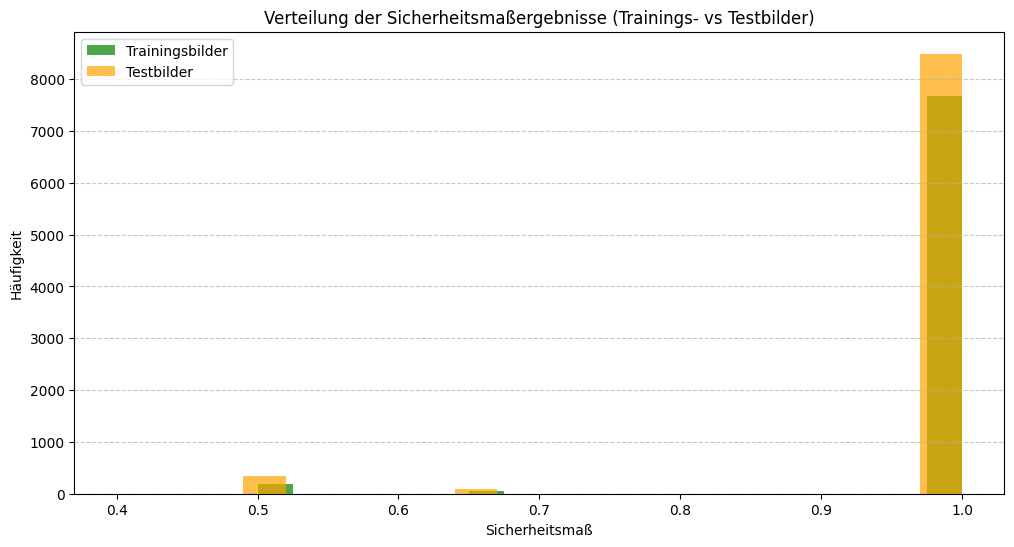

Durchschnittliche Sicherheit bei korrekter Klassifikation: 0.987
Durchschnittliche Sicherheit bei falscher Klassifikation: 0.909


In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Arrays für die Sicherheitswerte
correct_confidences = []
incorrect_confidences = []

# Analyse der Testdaten
for record in test_data_list:
    all_values = record.split(',')
    if len(all_values) != 785:
        continue

    correct_label = int(all_values[0])
    inputs = (numpy.asarray(all_values[1:], dtype=float) / 255.0 * 0.99) + 0.01
    ensemble_predictions = []

    for ensemble in ensembles:
        outputs = [model.query(inputs) for model in ensemble]
        predicted_labels = [i for i, output in enumerate(outputs) if output[0] > 0.5]
        ensemble_predictions.extend(predicted_labels)

    if ensemble_predictions:
        most_common = max(set(ensemble_predictions), key=ensemble_predictions.count)
        confidence = ensemble_predictions.count(most_common) / len(ensemble_predictions)

        if most_common == correct_label:
            correct_confidences.append(confidence)
        else:
            incorrect_confidences.append(confidence)

plt.figure(figsize=(12, 6))
plt.hist(confidence_scores_train, bins=20, alpha=0.7, label="Trainingsbilder", color='green')
plt.hist(confidence_scores_correct + confidence_scores_incorrect,
         bins=20,
         alpha=0.7,
         label="Testbilder",
         color='orange')
plt.title("Verteilung der Sicherheitsmaßergebnisse (Trainings- vs Testbilder)")
plt.xlabel("Sicherheitsmaß")
plt.ylabel("Häufigkeit")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Statistische Auswertung
print(f'Durchschnittliche Sicherheit bei korrekter Klassifikation: {np.mean(correct_confidences):.3f}')
print(f'Durchschnittliche Sicherheit bei falscher Klassifikation: {np.mean(incorrect_confidences):.3f}')

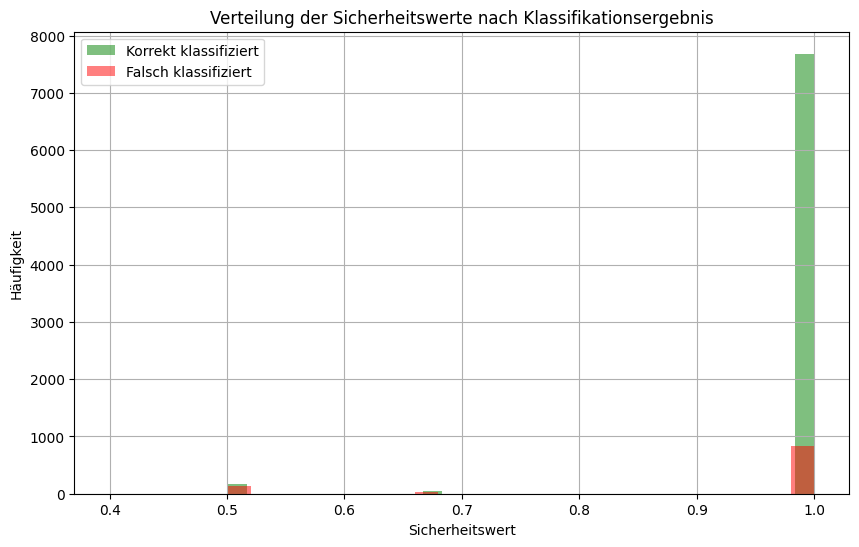

Durchschnittliche Sicherheit bei korrekter Klassifikation: 0.987
Durchschnittliche Sicherheit bei falscher Klassifikation: 0.919


In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Arrays für die Sicherheitswerte
correct_confidences = []
incorrect_confidences = []

# Analyse der Testdaten
for record in test_data_list:
    all_values = record.split(',')
    if len(all_values) != 785:
        continue

    correct_label = int(all_values[0])
    inputs = (numpy.asarray(all_values[1:], dtype=float) / 255.0 * 0.99) + 0.01
    ensemble_predictions = []

    for ensemble in ensembles:
        outputs = [model.query(inputs) for model in ensemble]
        predicted_labels = [i for i, output in enumerate(outputs) if output[0] > 0.5]
        ensemble_predictions.extend(predicted_labels)

    if ensemble_predictions:
        most_common = max(set(ensemble_predictions), key=ensemble_predictions.count)
        confidence = ensemble_predictions.count(most_common) / len(ensemble_predictions)

        if most_common == correct_label:
            correct_confidences.append(confidence)
        else:
            incorrect_confidences.append(confidence)

# Visualisierung
plt.figure(figsize=(10, 6))
plt.hist(correct_confidences, bins=30, alpha=0.5, label='Korrekt klassifiziert', color='green')
plt.hist(incorrect_confidences, bins=30, alpha=0.5, label='Falsch klassifiziert', color='red')
plt.xlabel('Sicherheitswert')
plt.ylabel('Häufigkeit')
plt.title('Verteilung der Sicherheitswerte nach Klassifikationsergebnis')
plt.legend()
plt.grid(True)
plt.show()

# Statistische Auswertung
print(f'Durchschnittliche Sicherheit bei korrekter Klassifikation: {np.mean(correct_confidences):.3f}')
print(f'Durchschnittliche Sicherheit bei falscher Klassifikation: {np.mean(incorrect_confidences):.3f}')

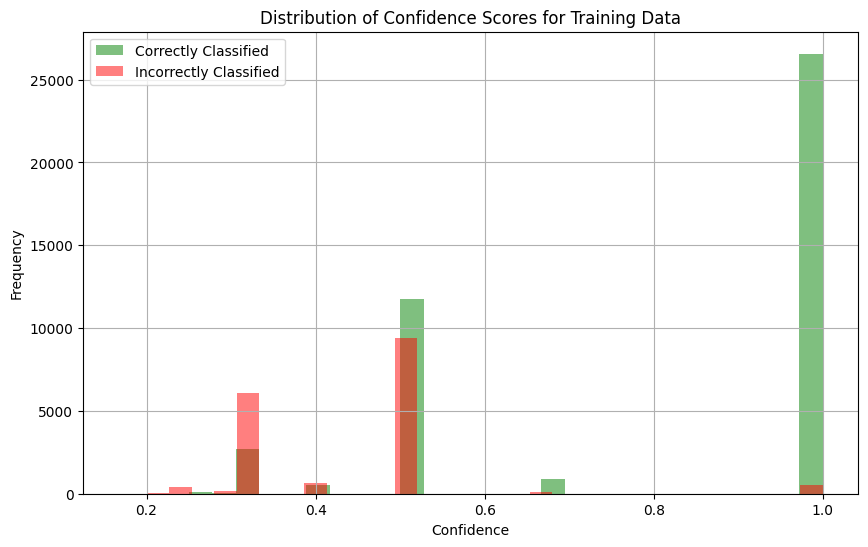

Average confidence for correct classification: 0.803
Average confidence for incorrect classification: 0.446
Total correct classifications: 42603
Total incorrect classifications: 17367


In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Arrays for the confidence values
correct_train_confidences = []
incorrect_train_confidences = []
correct_count = 0
incorrect_count = 0

# Analyze the training data
for record in training_data_list:
    all_values = record.split(',')
    if len(all_values) != 785:
        continue

    correct_label = int(all_values[0])
    inputs = (np.asarray(all_values[1:], dtype=float) / 255.0 * 0.99) + 0.01
    ensemble_predictions = []

    for ensemble in ensembles:
        outputs = [model.query(inputs) for model in ensemble]
        predicted_labels = [i for i, output in enumerate(outputs) if output[0] > 0.1]
        ensemble_predictions.extend(predicted_labels)

    if ensemble_predictions:
        most_common = max(set(ensemble_predictions), key=ensemble_predictions.count)
        confidence = ensemble_predictions.count(most_common) / len(ensemble_predictions)

        if most_common == correct_label:
            correct_train_confidences.append(confidence)
            correct_count += 1
        else:
            incorrect_train_confidences.append(confidence)
            incorrect_count += 1

# Visualization
plt.figure(figsize=(10, 6))
plt.hist(correct_train_confidences, bins=30, alpha=0.5, label='Correctly Classified', color='green')
plt.hist(incorrect_train_confidences, bins=30, alpha=0.5, label='Incorrectly Classified', color='red')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.title('Distribution of Confidence Scores for Training Data')
plt.legend()
plt.grid(True)
plt.show()

# Statistical evaluation
print(f'Average confidence for correct classification: {np.mean(correct_train_confidences):.3f}')
print(f'Average confidence for incorrect classification: {np.mean(incorrect_train_confidences):.3f}')
print(f'Total correct classifications: {correct_count}')
print(f'Total incorrect classifications: {incorrect_count}')